<a href="https://colab.research.google.com/github/koyomin9zx/CS313.K21-Homework/blob/master/Youtube_Spam_Detection-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

**download & extract dataset**

In [0]:
!wget -O data.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
!unzip data.zip

In [0]:
!pip install scikit-learn==0.23.1

**import lib**

In [0]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


**Import data into Pandas**

In [46]:
def load_data(path):
  all_files = glob.glob(path + "/*.csv")

  li = []

  for filename in all_files:
      data_frame = pd.read_csv(filename, index_col=None, header=0, encoding='utf-8')
      li.append(data_frame)

  df = pd.concat(li, axis=0, ignore_index=True)
  return df

df=load_data('/content')
df.head(5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13uwn2heqndtr5g304ccv5j5kqqzxjadmc0k,Corey Wilson,2015-05-28T21:39:52.376000,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,z124jvczaz3dxhnbc04cffk43oiugj25yzo0k,Epic Gaming,2015-05-28T20:07:20.610000,wierd but funny﻿,0
2,z13tczjy5xj0vjmu5231unho1ofey5zdk,LaS Music,2015-05-28T19:23:35.355000,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,z13tzr0hdpnayhqqc04cd3zqqqjkf3ngckk0k,Cheryl Fox,2015-05-28T17:49:35.294000,Party Rock....lol...who wants to shuffle!!!﻿,0
4,z12pcvix4zedcjvyb04ccr1r0mr2g5xwyng0k,PATRICK_TW,2015-05-28T16:28:26.818000,Party rock﻿,0


**DATA VISUALIZATION**

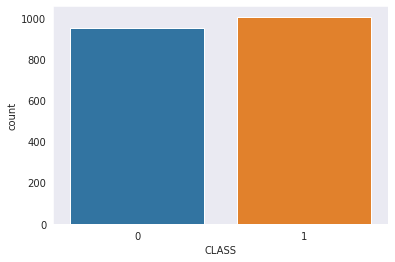

In [47]:
sns.set_style("dark")
sns.countplot(df.CLASS)

**See how our content look like**

In [7]:
  for i,content in enumerate (df['CONTENT'], 1):
    if i > 20:
        break
    else:
        print(i, content)



1 <a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part﻿
2 wierd but funny﻿
3 Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23giraffebruuh">#giraffebruuh</a>﻿
4 Party Rock....lol...who wants to shuffle!!!﻿
5 Party rock﻿
6 Shuffle﻿
7 Omg﻿
8 This song is just really fun ﻿
9 Awsome<br />﻿
10 wow!!!!!! increible song!!!!!!!!!﻿
11 I love this song so much﻿
12 2015 LIKEEE﻿
13 I miss when people dressed like this.﻿
14 2011- the last year of decent music.﻿
15 Best song ever!!!!﻿
16 super nice, love musique﻿
17 wowwwwwwwwwwwwwwwwwwwwwwwwwwwwww﻿
18 PARTY

**Text cleansing, remove digits, remove punctuation, remove html tags**

In [51]:
def remove_htmltag(text):
  cleanr = re.compile('<.*?>')
  return re.sub(cleanr, ' ', text)

def remove_punctuations(text):
  return text.translate(str.maketrans('', '', punctuation))

def remove_digits(text):
  return text.translate(str.maketrans('', '', digits))

hl_cleansed = []

for hl in df['CONTENT']:
    hl=remove_htmltag(hl)
    hl=remove_punctuations(hl)
    hl=remove_digits(hl)
    hl_cleansed.append(hl)
    
# View comparison
index=2
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter cleansed :')
print(hl_cleansed[index])

Original texts :
Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel="nofollow" class="ot-hashtag" href="https://plus.google.com/s/%23giraffebruuh">#giraffebruuh</a>﻿

After cleansed :
Hey guys Im a human   But I dont want to be a human I want to be a sexy fucking giraffe   I already have the money for the surgery to elongate my spinal core the surgery to change my skin pigment and everything else Like this post so others can root me on in my dream   Im fucking with you I make music check out my first song  giraffebruuh ﻿


**Tokenization**

In [59]:
def token_seq(text):
  return text.split()

# Tokenization process
hl_tokens = []
for hl in hl_cleansed:
    hl_tokens.append(hl.split())

# View Comparison
index=2
print('Before tokenization :')
print(hl_cleansed[index])
print('\nAfter tokenization :')
print(hl_tokens[index])

Before tokenization :
Hey guys Im a human   But I dont want to be a human I want to be a sexy fucking giraffe   I already have the money for the surgery to elongate my spinal core the surgery to change my skin pigment and everything else Like this post so others can root me on in my dream   Im fucking with you I make music check out my first song  giraffebruuh ﻿

After tokenization :
['Hey', 'guys', 'Im', 'a', 'human', 'But', 'I', 'dont', 'want', 'to', 'be', 'a', 'human', 'I', 'want', 'to', 'be', 'a', 'sexy', 'fucking', 'giraffe', 'I', 'already', 'have', 'the', 'money', 'for', 'the', 'surgery', 'to', 'elongate', 'my', 'spinal', 'core', 'the', 'surgery', 'to', 'change', 'my', 'skin', 'pigment', 'and', 'everything', 'else', 'Like', 'this', 'post', 'so', 'others', 'can', 'root', 'me', 'on', 'in', 'my', 'dream', 'Im', 'fucking', 'with', 'you', 'I', 'make', 'music', 'check', 'out', 'my', 'first', 'song', 'giraffebruuh', '\ufeff']


**Lemmatization**

In [10]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

hl_lemmatized = []
for tokens in hl_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    hl_lemmatized.append(lemm)
    
# Example comparison
word_1 = ['skyrim','dragons', 'are', 'having', 'parties']
word_2 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_1]
print('Before lemmatization :\t',word_1)
print('After lemmatization :\t',word_2)

Before lemmatization :	 ['skyrim', 'dragons', 'are', 'having', 'parties']
After lemmatization :	 ['skyrim', 'dragon', 'be', 'have', 'party']


# ***Training LSTM Model***

In [0]:
# Vectorize and convert text into sequences
def vectorize_lstm(text):
  text=word_lenmatizer(text)
  sequences = tokenizer.texts_to_sequences(text)
  X = pad_sequences(sequences, maxlen=14)
  return X

max_features = 2000
max_token = len(max(hl_lemmatized))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_lemmatized)
sequences = tokenizer.texts_to_sequences(hl_lemmatized)
X = pad_sequences(sequences, maxlen=max_token)

Split Train, Test

In [0]:
Y = df['CLASS'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

Building the Model

In [22]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 14, 64)            128000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 189,921
Trainable params: 189,921
Non-trainable params: 0
_________________________________________________________________
None


Training process

In [23]:
epoch = 10
batch_size = 128
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1095 samples, validate on 274 samples
Epoch 1/10
 - 1s - loss: 0.6909 - accuracy: 0.6110 - val_loss: 0.6870 - val_accuracy: 0.6715
Epoch 2/10
 - 0s - loss: 0.6768 - accuracy: 0.7169 - val_loss: 0.6695 - val_accuracy: 0.6679
Epoch 3/10
 - 0s - loss: 0.6325 - accuracy: 0.7251 - val_loss: 0.6206 - val_accuracy: 0.6788
Epoch 4/10
 - 0s - loss: 0.5387 - accuracy: 0.7479 - val_loss: 0.5502 - val_accuracy: 0.7044
Epoch 5/10
 - 0s - loss: 0.4060 - accuracy: 0.8274 - val_loss: 0.4470 - val_accuracy: 0.8029
Epoch 6/10
 - 0s - loss: 0.3111 - accuracy: 0.8913 - val_loss: 0.3771 - val_accuracy: 0.8540
Epoch 7/10
 - 0s - loss: 0.2378 - accuracy: 0.9132 - val_loss: 0.3700 - val_accuracy: 0.8613
Epoch 8/10
 - 0s - loss: 0.2130 - accuracy: 0.9178 - val_loss: 0.4153 - val_accuracy: 0.8869
Epoch 9/10
 - 1s - loss: 0.1866 - accuracy: 0.9269 - val_loss: 0.3085 - val_accuracy: 0.8650
Epoch 10/10
 - 0s - loss: 0.1471 - accuracy: 0.9479 - val_loss: 0.4001 - val_accuracy: 0.8723


# ***Model Evaluation***



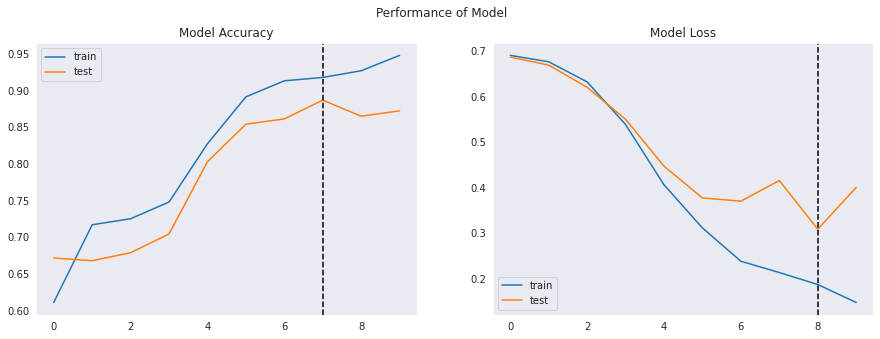

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# ***Test Model***

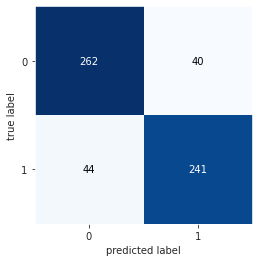

In [25]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [26]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       302
           1       0.86      0.85      0.85       285

    accuracy                           0.86       587
   macro avg       0.86      0.86      0.86       587
weighted avg       0.86      0.86      0.86       587



# ***Use Another ML Algorithms to Classify***

**Preparing the Data**

In [0]:
X = [" ".join(x) for x in hl_lemmatized]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['CLASS'],test_size=0.3)

**Word Vectorization using TF-IDF**

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [76]:
print(Tfidf_vect.vocabulary_)

{'best': 295, 'part': 2375, 'wierd': 3556, 'but': 413, 'funny': 1174, 'hey': 1375, 'guy': 1301, 'im': 1642, 'human': 1601, 'dont': 816, 'want': 3471, 'to': 3260, 'be': 260, 'sexy': 2837, 'fuck': 1163, 'giraffe': 1218, 'already': 103, 'have': 1344, 'the': 3206, 'money': 2146, 'for': 1117, 'surgery': 3126, 'elongate': 897, 'my': 2202, 'spinal': 3006, 'core': 625, 'change': 469, 'skin': 2914, 'pigment': 2434, 'and': 131, 'everything': 967, 'else': 898, 'like': 1900, 'this': 3230, 'post': 2497, 'so': 2945, 'others': 2346, 'can': 426, 'root': 2751, 'me': 2051, 'on': 2321, 'in': 1656, 'dream': 830, 'with': 3575, 'you': 3652, 'make': 2020, 'music': 2189, 'check': 488, 'out': 2352, 'first': 1090, 'song': 2964, 'giraffebruuh': 1219, 'party': 2376, 'rocklolwho': 2745, 'shuffle': 2879, 'rock': 2743, 'omg': 2318, 'just': 1781, 'really': 2645, 'fun': 1171, 'awsome': 226, 'wow': 3604, 'increible': 1667, 'love': 1971, 'much': 2181, 'likeee': 1905, 'miss': 2122, 'when': 3537, 'people': 2404, 'dress': 

## **Trainning on the SVM classifier**

In [29]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(kernel='linear', verbose=True)

**Predict and evaluate the SVM classifier**

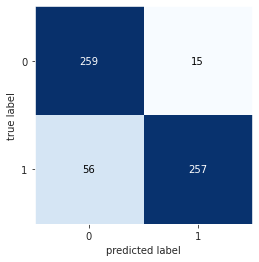

In [30]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [31]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       274
           1       0.94      0.82      0.88       313

    accuracy                           0.88       587
   macro avg       0.88      0.88      0.88       587
weighted avg       0.89      0.88      0.88       587



## **Trainning on the Naive Bayes Classifier**

In [32]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB()

**Predict and evaluate the Naive Bayes Classifier**

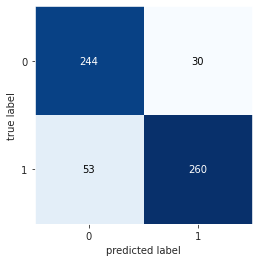

In [33]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [0]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       287
           1       0.88      0.85      0.86       300

    accuracy                           0.86       587
   macro avg       0.86      0.86      0.86       587
weighted avg       0.86      0.86      0.86       587



# ***Save model***

In [75]:
joblib.dump(Tfidf_vect, '/content/drive/My Drive/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/drive/My Drive/modeltokenizer_LSTM.pkl')
joblib.dump(model, '/content/drive/My Drive/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/drive/My Drive/model/SVM_model.pkl')
joblib.dump(Naive, '/content/drive/My Drive/model/NB_model.pkl')
joblib.dump(Tfidf_vect.vocabulary_,'/content/drive/My Drive/model/vocalbulary.pkl' )

['/content/drive/My Drive/model/vocalbulary.pkl']

# ***Enter comment and check***

## *utils*

In [0]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re
import string
from string import digits, punctuation

def remove_htmltag(text):
  cleanr = re.compile('<.*?>')
  return re.sub(cleanr, ' ', text)

def remove_punctuations(text):
  return text.translate(str.maketrans('', '', punctuation))

def remove_digits(text):
  return text.translate(str.maketrans('', '', digits))


def word_lenmatizer(text):
    cleanr = re.compile('<.*?>')
    text=re.sub(cleanr, ' ', text)
    clean = text.translate(str.maketrans('', '', punctuation))
    clean = clean.translate(str.maketrans('', '', digits))
    text_tokenizer=clean.split()
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    hl_lemmatized = []
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_tokenizer]
    hl_lemmatized.append(lemm)
    return hl_lemmatized

def vectorize_lstm(text):
  text=word_lenmatizer(text)
  sequences = tokenizer.texts_to_sequences(text)
  X = pad_sequences(sequences, maxlen=14)
  return X


def vectorize_clasifer(text, tfidf_vector):
  w_lenmatizer=word_lenmatizer(text)
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  return tfidf_vector.transform(w_lenmatizer)


def LSTM_predict(text,model,tokenizer):
  w_lenmatizer=word_lenmatizer(text)
  max_token = 14
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=max_token)
  if np.around(model.predict(X)[0])==1:
    print(text)
    print("=============> SPAM\n")
  else:
    print(text)
    print("=============> HAM\n")

def predict(text,model,tfidf_vector):
  w_lenmatizer=word_lenmatizer(text)
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  X_Tfidf = tfidf_vector.transform(w_lenmatizer)
  if model.predict(X_Tfidf)[0]==1:
    print(text)
    print("=============> SPAM\n")
  else:
    print(text)
    print("=============> HAM\n")





## Predict

Load model 

In [40]:
model_LSTM=joblib.load('/content/model/LSTM_model.pkl')
tokenizer_LSTM=joblib.load('/content/model/tokenizer_LSTM.pkl')
SVM_model=joblib.load('/content/model/SVM_model.pkl')
NB_model=joblib.load('/content/model/NB_model.pkl')
tfidf_vec=joblib.load('/content/model/tfidf.pkl')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using LSTM model to predict

In [41]:
cmt='Please subcribe my channel'
LSTM_predict(cmt,model_LSTM,tokenizer_LSTM)


cmt2='I just remembered the song because of Alvin and The Chipmunks 😂'
LSTM_predict(cmt2,model_LSTM,tokenizer_LSTM)

Please subcribe my channel
=============> SPAM

I just remembered the song because of Alvin and The Chipmunks 😂
=============> HAM



Using SVM clasifier

In [42]:
cmt='Follow me on instagram, remember to like and subcribe'
predict(cmt,SVM_model,tfidf_vec)


cmt2='This is probably the best song that represents the world cup ever.'
predict(cmt2,SVM_model,tfidf_vec)

Follow me on instagram, remember to like and subcribe
=============> SPAM

This is probably the best song that represents the world cup ever.
=============> HAM



Using NB clasifier


In [43]:
cmt='Such a shame that this song didnt reach 1B in 10 years.'
predict(cmt,NB_model,tfidf_vec)


cmt2='LIKE THIS COMMENT IF YOU ARE WATCHING.'
predict(cmt2,NB_model,tfidf_vec)

Such a shame that this song didnt reach 1B in 10 years.
=============> HAM

LIKE THIS COMMENT IF YOU ARE WATCHING.
=============> SPAM

